## Apartado 2. Series temporales con Datashaders

En este apartado trabajaremos con el dataset de los datos de calidad del aire por horas de Castilla y León. En concreto, nos centraremos en la estación Renault1 de la provincia de Valladolid.

En la columna Fecha aparece la fecha y la hora de cada medida.

Queremos representar gráficamente esta serie temporal utilizando Datashader. Debéis obtener las siguientes tres imágenes:  
	1.	Serie temporal de la variable monóxido de nitrógeno (NO (µg/m³)).  
	2.	Serie temporal de la variable dióxido de nitrógeno (NO₂ (µg/m³)).  
	3.	Ambas series en una única imagen, cada una con un color diferente.

In [1]:
!pip install datashader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 28.8 MB/s eta 0:00:00


In [2]:
import pandas as pd

df = pd.read_csv('https://datosabiertos.jcyl.es/web/jcyl/risp/es/medio-ambiente/calidad-aire-historico-horario/1284808467480.csv', sep=';')
df.head()

<ipython-input-2-caaa7a869745>:3: DtypeWarning: Columns (2,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('https://datosabiertos.jcyl.es/web/jcyl/risp/es/medio-ambiente/calidad-aire-historico-horario/1284808467480.csv', sep=';')


,Fecha,CO (mg/m3),NO (ug/m3),NO2 (ug/m3),O3 (ug/m3),PM10 (ug/m3),PM25 (ug/m3),SO2 (ug/m3),Provincia,Estación,Latitud,Longitud
0,31/12/2018 24,NaN,3.0,33.0,NaN,13.0,NaN,7.0,León,C.T.Compostilla-Compostilla,42.570833,-6.589444
1,31/12/2018 24,NaN,52.0,33.0,2.0,NaN,NaN,NaN,Valladolid,Renault1,41.600000,-4.732500
2,31/12/2018 24,NaN,9.0,22.0,41.0,7.0,NaN,8.0,Soria,Soria,41.766667,-2.466667
3,31/12/2018 24,NaN,2.0,2.0,50.0,1.0,1.0,NaN,Palencia,C.T.G. - Compuerto,42.849167,-4.835833
4,31/12/2018 24,NaN,1.0,9.0,34.0,4.0,NaN,1.0,León,C.T.L.R. - Cuadros,42.715556,-5.638889


In [3]:
df_renault1 = df[(df['Estación'] == 'Renault1') & (df['Provincia'] == 'Valladolid')].copy()

def fix_hour_24(date_str):
    if ' 24' in date_str:
        return pd.to_datetime(date_str.replace(' 24', ' 00'), format='%d/%m/%Y %H') + pd.Timedelta(days=1)
    return pd.to_datetime(date_str, format='%d/%m/%Y %H', errors='coerce')

df_renault1['Fecha'] = df_renault1['Fecha'].apply(fix_hour_24)
df_renault1.dropna(subset=['Fecha'], inplace=True)

df_renault1['Timestamp'] = df_renault1['Fecha'].astype('int64') // 10**9

df_renault1.head()

,Fecha,CO (mg/m3),NO (ug/m3),NO2 (ug/m3),O3 (ug/m3),PM10 (ug/m3),PM25 (ug/m3),SO2 (ug/m3),Provincia,Estación,Latitud,Longitud,Timestamp
1,2019-01-01 00:00:00,NaN,52.0,33.0,2.0,NaN,NaN,NaN,Valladolid,Renault1,41.6,-4.7325,1546300800
97,2018-12-31 23:00:00,NaN,33.0,36.0,1.0,NaN,NaN,NaN,Valladolid,Renault1,41.6,-4.7325,1546297200
137,2018-12-31 22:00:00,NaN,48.0,45.0,2.0,NaN,NaN,NaN,Valladolid,Renault1,41.6,-4.7325,1546293600
173,2018-12-31 21:00:00,NaN,58.0,57.0,1.0,NaN,NaN,NaN,Valladolid,Renault1,41.6,-4.7325,1546290000
222,2018-12-31 20:00:00,NaN,86.0,67.0,1.0,NaN,NaN,NaN,Valladolid,Renault1,41.6,-4.7325,1546286400


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 272, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  wa

CPU times: user 19.5 ms, sys: 0 ns, total: 19.5 ms
Wall time: 29.3 ms


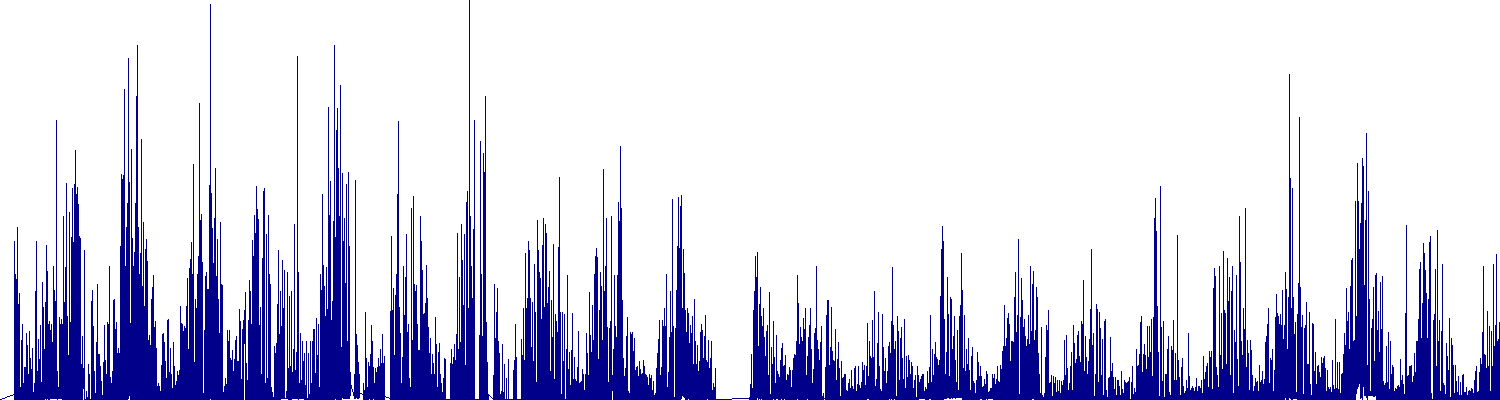

In [4]:
import datashader as ds
import datashader.transfer_functions as tf

df_1 = df_renault1[df_renault1['NO (ug/m3)'].notna()].copy()
df_1['NO (ug/m3)'] = pd.to_numeric(df_1['NO (ug/m3)'], errors='coerce')

x_range_1 = (df_1['Timestamp'].min(), df_1['Timestamp'].max())
y_range_1 = (df_1['NO (ug/m3)'].min(), df_1['NO (ug/m3)'].max())

cvs_1 = ds.Canvas(x_range=x_range_1, y_range=y_range_1, plot_height=400, plot_width=1500)
agg_1 = cvs_1.line(df_1, 'Timestamp', 'NO (ug/m3)')

%time tf.shade(agg_1)

CPU times: user 27.7 ms, sys: 0 ns, total: 27.7 ms
Wall time: 27.9 ms


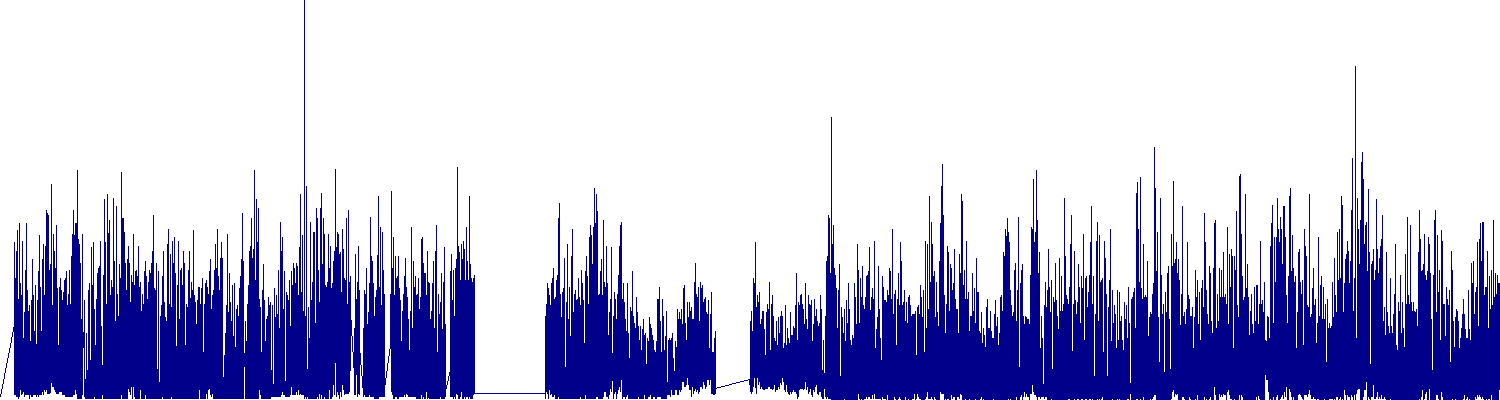

In [5]:
df_2 = df_renault1[df_renault1['NO2 (ug/m3)'].notna()].copy()
df_2['NO2 (ug/m3)'] = pd.to_numeric(df_2['NO2 (ug/m3)'], errors='coerce')

x_range_2 = (df_2['Timestamp'].min(), df_2['Timestamp'].max())
y_range_2 = (df_2['NO2 (ug/m3)'].min(), df_2['NO2 (ug/m3)'].max())

cvs_2 = ds.Canvas(x_range=x_range_2, y_range=y_range_2, plot_height=400, plot_width=1500)
agg_2 = cvs_2.line(df_2, 'Timestamp', 'NO2 (ug/m3)')

%time tf.shade(agg_2)

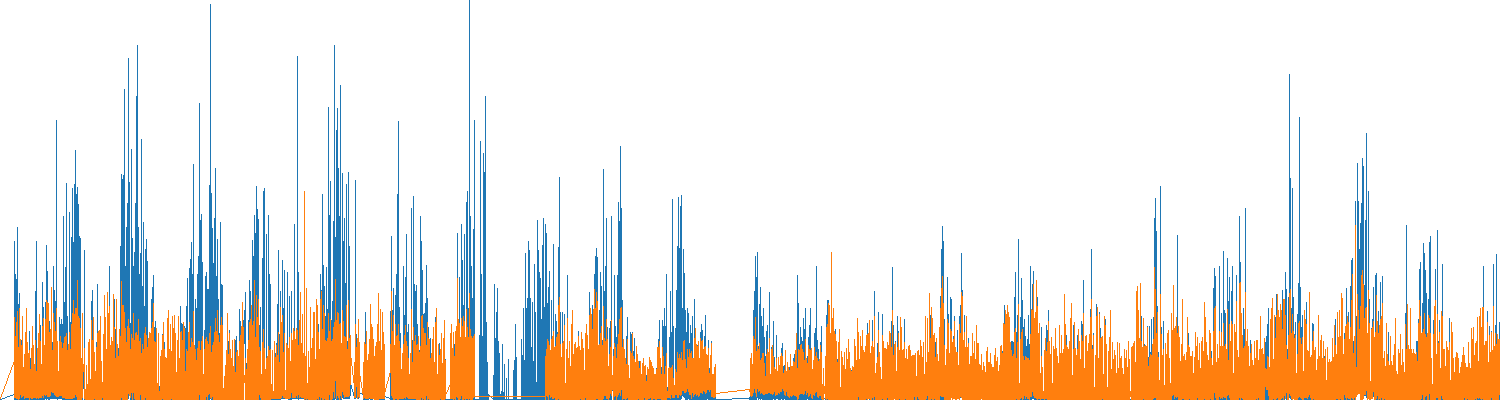

In [10]:
x_range = (df_renault1['Timestamp'].min(), df_renault1['Timestamp'].max())
y_range_no = (df_1['NO (ug/m3)'].min(), df_1['NO (ug/m3)'].max())
y_range_no2 = (df_2['NO2 (ug/m3)'].min(), df_2['NO2 (ug/m3)'].max())

cvs = ds.Canvas(x_range=x_range, y_range=(min(y_range_no[0], y_range_no2[0]), max(y_range_no[1], y_range_no2[1])), plot_height=400, plot_width=1500)

agg_no = cvs.line(df_1, 'Timestamp', 'NO (ug/m3)')
agg_no2 = cvs.line(df_2, 'Timestamp', 'NO2 (ug/m3)')

img_no = tf.shade(agg_no, cmap=["#1f77b4"])
img_no2 = tf.shade(agg_no2, cmap=["#ff7f0e"])

# Superpone ambas imágenes
final_img = tf.stack(img_no, img_no2)

final_img